<a href="https://colab.research.google.com/github/SELips/Shark_attacks/blob/main/Shark_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take this dataset: https://www.kaggle.com/felipeesc/shark-attack-dataset. Use all the skills you've learned up until now to answer the following questions as well as possible.

1. what are the most dangerous types of sharks to humans?
2. are children more likely to be attacked by sharks?
3. are shark attacks where sharks were provoked more or less dangerous?
4. are certain activities more likely to result in a shark attack?

If you feel you can't answer a question based on the dataset alone, feel free to find other datasets and use them in answering the questions.

For each answer you give not only answer the question but also write about the assumptions you made in answering the question. If an assumption or decision possibly created a bias please write about this as well.

In [ ]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
%reload_ext google.colab.data_table
#Zet copy error uit omdat het vals positieven geeft.
pd.options.mode.chained_assignment = None

df = pd.read_csv("https://raw.githubusercontent.com/SELips/Shark_attacks/main/attacks.csv", encoding = 'cp1252')


In [ ]:
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column): 
  unique_values_cutoff = 100
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print("Values are sorted")
      display(list(sorted))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 100
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)


def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")


def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]  

  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)

  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")


def replace_value(df, column_name, missing_old, missing_new):
  # ⚠️ Mutates df
  df[column_name] = df[column_name].replace({missing_old: missing_new})

# Helper functions
def display_default_null_values(df, column_name):
  nulls = df.loc[df[column_name].isnull()]
  print(f"Number of default null values in \"{column_name}\": {len(nulls)}")


# Easier to type
nat = np.datetime64('nat')


**VOORAF**

Ik heb door de dataframe heen gescrolled en met de code uit vorige opdrachten gekeken naar de edges, de frequency, het type data en de unieke waardes van de kolommen. Met de vier vragen in mijn achterhoofd die ik moet beantwoorden, heb ik er voor gekozen om een aantal kolommen te verwijderen om het overzichtelijker te maken en ook om lege rijen te verwijderen.

In [ ]:
#alle rijen waarin 'date' leeg is, bevatten geen informatie. Die drop ik.
df1 = df.dropna(subset=['Date']).copy()
#Door het kijken naar de kolommen, en welke informatie ik nodig heb of zou kunnen hebben voor de vier vragen verwijder ik alle kolommen nu geen toevoeging hebben.
#Evenals dubbele kolommen.
df2 = df1.drop(columns=["Case Number","Year", "Case Number.1", "Case Number.2", "pdf", "href formula", "href", "Investigator or Source", "original order", "Unnamed: 22", "Unnamed: 23"])
#Hernoem de kolommen.
df3 = df2.rename(columns={"Species ":"Species", "Sex ": "Sex","Fatal (Y/N)" : "Fatal"})
#Verwijder type ongelukken en haaiensoorten die invalid zijn, en questionable activiteiten. Aanname: deze 'Invalid's' bevatten te weinig informatie om te gebruiken voor de vier vragen.
df3 = df3[(df3.Species != 'Invalid') & (df3.Type != 'Invalid') & (df3.Type != 'Questionable')]

# **Question 1**

what are the most dangerous types of sharks to humans?

**Antwoord:**

Great white sharks zijn de gevaarlijkste haaisoorten voor mensen, voor zowel het aantal fatale als niet-fatale ontmoetingen. Deze soort stijgt er met kop en schouders bovenuit, want op de tweede plek staan tiger sharks, die minder dan 40% van het totale aantal ontmoetingen hebben gehad en ongeveer de helft aan fatale aanvallen. Dit wordt gevolgd door bull sharks. 

Wat wel opvalt is dat het aantal totale ontmoetingen met basking en galapagos (niet in de top 10) sharks relatief laag is met een hoger aantal fatale aanvallen (>28%). Deze haaien zijn hierdoor relatief dodelijk bij een aanval. Tiger shark aanvallen zijn in 26% gevallen dodelijk, wat binnen de top 10 het dodelijkst is. 



In [ ]:
#De vraag: what are the most dangerous sharks to humans? kan op verschillende manieren geïnterpreteerd worden.
#Ik wil deze vraag op twee manieren beantwoorden: Het aantal totale ontmoetingen en het aantal fatale ontmoetingen.
#Mijn aanname hierin is dat voor deel 1 alle encounters even gevaarlijk zijn en voor deel 2 alleen de fatale encounters gevaarlijk zijn. 

#De belangrijkste kolommen voor deze vraag zijn de "species" en "Fatal" kolom
#De "species" kolom is vaak meer beschrijvend dan een benaming, eg. 1.5m long bull shark i.p.v. bull shark.
#Naast de beschrijvingen zijn er ook veel kolommen met een NaN-value of onzekerheden. 

#Aannames n.a.v. het checken van unieke waarden etc:
#Overal waar de woorden: 'involve| or |questionable|thought|possibl|probable|allegedly|hoax|believed|Unidentified||\?|Said to be|unlikely' in voor komen
#lijkt te gaan om een onzekerheid m.b.t. het soort haai. Deze zet ik allemaal om naar 'Not identified'. 
#Ik heb een lijst met de bekendste haaisoorten en haaisoorten die mensen hebben aangevallen aangewend om zoveel mogelijk haaien in de lijst om te kunnen schrijven
#Bij het checken van de unique values heb ik haaien die niet als soort maar als familie er in staan, eg. reef shark i.p.v. caribbean reef shark ook als 'Not identified' gekwalificeerd.
#D.m.v. trial en error heb ik eventuele valkuilen kunnen omzeilen. eg. Als een string 'whale' bevat moet het alleen 'whale shark' worden als het geen 'whaler' bevat.
#De NaN-values heb ik in de originele dataset naar een lege string omgeschreven en vervolgens in de 'New_species' omgeschreven naar 'not identified'.

#Stap 1: Frequency check van haaiensoorten in een nieuw dataframe (anders geeft value_counts te weinig terug).
# Frequency_of_sharks = df3.Species.value_counts().to_frame()
# display(Frequency_of_sharks)

#Stap 2: Voeg een nieuwe kolom toe genaamd New_species met in elke cel het woord 'Not identified' vanuit daar kunnen we de haaien gaan identificeren.
#Zoek vervolgens in de species kolom naar bepaalde woorden (zie stap 3), en als aan die voorwaarde wordt voldaan hernoem het dan naar de common name in de New_species kolom.
#Onderstaande is op alfabetische volgorde. 
df4 = df3
df4["New_species"] = "Not identified"
df4['Species']=df4['Species'].replace({np.nan : 'None', " ":"None", "":"None"})
Not_identified = 'involve| or |invalid|thought|possibl|probable|allegedly|None|hoax|believed|Unidentified|\?|Said to be|unlikely'
df4['New_species'][df4['Species'].fillna('').str.contains('angel', case = False)] = 'Angel shark'
df4['New_species'][df4['Species'].fillna('').str.contains('basking', case = False)] = 'Basking shark'
df4['New_species'][df4['Species'].fillna('').str.contains('black', case = False)] = 'Blacktip shark'
df4['New_species'][df4['Species'].fillna('').str.contains('bull|zambezi|zambesi', case = False)   ] = 'Bull shark'
df4['New_species'][df4['Species'].fillna('').str.contains('caribbean', case = False)] = 'Caribbean Reef shark'
df4['New_species'][df4['Species'].fillna('').str.contains('wobbegong|carpet', case = False)] = 'Carpet shark'
df4['New_species'][df4['Species'].fillna('').str.contains('bronze whaler|copper shark', case = False)] = 'Copper shark'
df4['New_species'][df4['Species'].fillna('').str.contains('cookiecutter', case = False)] = 'Cookiecutter shark'
df4['New_species'][df4['Species'].fillna('').str.contains('dusky', case = False)] = 'Dusky shark'
df4['New_species'][df4['Species'].fillna('').str.contains('galapagos', case = False)] = 'Galapagos shark'
df4['New_species'][df4['Species'].fillna('').str.contains('goblin', case = False)] = 'Goblin shark'
df4['New_species'][df4['Species'].fillna('').str.contains('blue shark|blue whaler', case = False)] = 'Great blue shark'
df4['New_species'][df4['Species'].fillna('').str.contains('white shark', case = False)] = 'Great white shark'
df4['New_species'][df4['Species'].fillna('').str.contains('grey reef|gray reef', case = False)] = 'Grey reef shark'
df4['New_species'][df4['Species'].fillna('').str.contains('hammerhead', case = False)] = 'Hammerhead shark'
df4['New_species'][df4['Species'].fillna('').str.contains('horn', case = False)] = 'Horn shark'
df4['New_species'][df4['Species'].fillna('').str.contains('lemon', case = False)] = 'Lemon shark'
df4['New_species'][df4['Species'].fillna('').str.contains('leopard', case = False)] = 'Leopard shark'
df4['New_species'][df4['Species'].fillna('').str.contains('nurse', case = False) & ~df4['Species'].fillna('').str.contains('tawny|grey', case = False)   ] = 'Nurse shark'
df4['New_species'][df4['Species'].fillna('').str.contains('whitetip|brown|silvertip|white-tip', case = False)   ] = 'Oceanic whitetip shark'
df4['New_species'][df4['Species'].fillna('').str.contains('porbeagle', case = False)] = 'Porbeagle shark'
df4['New_species'][df4['Species'].fillna('').str.contains('port jackson', case = False)] = 'Port Jackson shark'
df4['New_species'][df4['Species'].fillna('').str.contains('brown|sandbar', case = False)] = 'Sandbar shark'
df4['New_species'][df4['Species'].fillna('').str.contains('sandtiger|raggedtooth|grey nurse', case = False)] = 'Sandtiger shark' #Meerdere common names
df4['New_species'][df4['Species'].fillna('').str.contains('salmon', case = False)] = 'Salmon shark'
df4['New_species'][df4['Species'].fillna('').str.contains('blue pointer|mako', case = False)] = 'Shortfin mako shark'
df4['New_species'][df4['Species'].fillna('').str.contains('shovelnose guitarfish', case = False)] = 'Shovelnose guitarfish'
df4['New_species'][df4['Species'].fillna('').str.contains('silky', case = False)] = 'Silky shark'
df4['New_species'][df4['Species'].fillna('').str.contains('spinner', case = False)] = 'Spinner shark'
df4['New_species'][df4['Species'].fillna('').str.contains('sevengill|seven-gill|7-gill', case = False)] = 'Sevengill shark'
df4['New_species'][df4['Species'].fillna('').str.contains('dog', case = False)] = 'Spiny dog fish'
df4['New_species'][df4['Species'].fillna('').str.contains('tawny', case = False)] = 'Tawny nurse shark'
df4['New_species'][df4['Species'].fillna('').str.contains('thresher', case = False)] = 'Thresher shark'
df4['New_species'][df4['Species'].fillna('').str.contains('tiger', case = False) & ~df4['Species'].fillna('').str.contains('sandtiger', case = False)   ] = 'Tiger shark'
df4['New_species'][df4['Species'].fillna('').str.contains('whale shark', case = False)& ~df4['Species'].fillna('').str.contains('whaler', case = False)] = 'Whale shark'
df4['New_species'][df4['Species'].fillna('').str.contains(Not_identified, case = False)] = 'Not identified'

#Stap 3: Elke haai uit de lijsten die ik heb aangewend zoek ik op met onderstaande code om te zien of en op wat voor manier ze voorkomen. 
#Daarna nog als test om te zien of mijn omzettingen goed zijn gegaan
# df4 = df4[df4["Species"].str.contains("White", case = False)==True]
# display(df4)

#Stap 4: Fatal is de andere kolom die ik nodig heb.
#find_non_default_missing_values(df4, 'Fatal', 'String') geeft als unieke waarden:
#['N', 'Y', nan, 'M', 'UNKNOWN', '2017', ' N', 'N ', 'y']
#De fatal kolom moet worden omgeschreven naar Y, N en unknown. M en 2017 waren niet fatal.  
df4['Fatal'] = df4['Fatal'].replace({"N ": "N", " N": "N", "y":"Y", np.nan: "UNKNOWN", "M":"N", "2017":"N"})

,species_q1_total,species_q1_fatal,percentage_dodelijk
Great white shark,591,128.0,0.216582
Tiger shark,231,61.0,0.264069
Bull shark,174,34.0,0.195402
Sandtiger shark,95,NaN,NaN
Blacktip shark,67,1.0,0.014925
Copper shark,61,2.0,0.032787
Shortfin mako shark,57,5.0,0.087719
Carpet shark,54,NaN,NaN
Nurse shark,53,NaN,NaN
Hammerhead shark,38,NaN,NaN


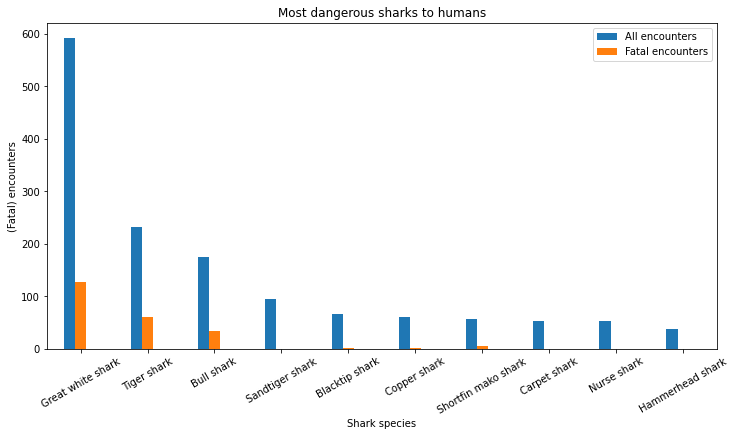

In [ ]:
#Weergeven van de aanvallen en dodelijke aanvallen met haaien. Om een antwoord te kunnen geven op de vraag.
#Not identified telt niet mee, en maak een nieuwe df met als index haaiensoort, en als twee kolommen aantal encounters en fatalities. Hou de top 10. 
df_q1_part1 = df4.loc[(df4["New_species"] != "Not identified")]
df_q1_part1 = df_q1_part1.rename(columns={"New_species":"species_q1_total"})
df_q1_part2 = df4.loc[(df4["Fatal"] == "Y") & (df4["New_species"] != "Not identified")]
df_q1_part2 = df_q1_part2.rename(columns={"New_species":"species_q1_fatal"})
df_q1_part1 = df_q1_part1.species_q1_total.value_counts()
df_q1_part2 = df_q1_part2.species_q1_fatal.value_counts()

#Voeg twee dataframes samen en voeg kolom toe die laat zien hoe dodelijk een haaienaanval is. 
result = pd.concat([df_q1_part1,df_q1_part2],axis=1)
result_percentage = result
result_percentage['percentage_dodelijk'] = result["species_q1_fatal"]/result["species_q1_total"]
display(result_percentage)


#maak de grafiek met twee bar charts. 
result = result.head(10)
axes = result.plot.bar(figsize=(12,6),rot=30)
axes.set_title("Most dangerous sharks to humans")
axes.set_ylabel("(Fatal) encounters")
axes.set_xlabel("Shark species")
plt.xticks(rotation=30, horizontalalignment = 'center')
legend_labels = ["All encounters", "Fatal encounters"]
plt.legend(legend_labels)

# **Question 2**

Are children more likely to be attacked by sharks?

**Antwoord:**

Voor dit antwoord kijk ik naar de grafiek en naar de twee data_frames die ik heb gemaakt met all encounters en fatal encounters voor de kolom Child_attack.

De grafiek geeft aan dat de piek van aanvallen bij tieners ligt, zo tussen de 15-20 jaar en dat het vanaf daar steeds minder wordt. Dit geldt voor zowel fatale als niet fatale aanvallen. 

Kijkend naar de cijfers, waarbij ik voor het antwoord de unknown's negeer zie ik eenzelfde beeld.

Ik ga er vanuit dat een mens gemiddeld 80 jaar oud wordt. Als je tot je 20ste kind bent betekent dit dat je dus 25% van je leven doorbrengt als kind. 

Het aantal volwassen dat (fataal) wordt aangevallen ligt in beide gevallen ~80% hoger. Dit zou niet heel erg moeten zijn aangezien er meer volwassen bestaan. Maar als we kijken naar percentages van totaal aantal aanvallen dan zie ik dat bij beide aanvallen (fataal en niet-fataal) kinderen in ~33% van de gevallen betrokken zijn. Dit is meer dan de tijd die je als kind doorbrengt.

Kinderen hebben een grotere kans om aangevallen te worden door een haai.  


,All_encounters,Fatal_encounters
Uknown,2568,782
Adult,2035,382
Child,1150,217


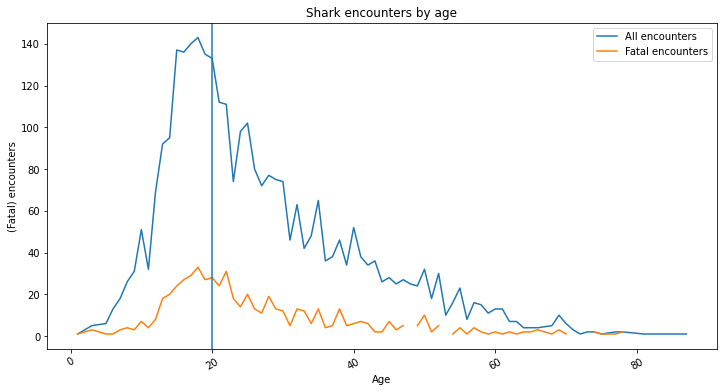

In [ ]:
#Ik ga hiervoor verder met df4, omdat ik in deze dataframe al onnodige kolommen heb verwijderd en de haaisoort mooi heb geordend lijkt me dit een goede basis.
#De vraag betreft kinderen, mijn aanname hierin is dat alle mensen onder de 20 kind zijn, overgenomen uit de WHO.
#Met de functie om te kijken naar de frequentie, soort data, edges etc kom ik er achter dat er naast getallen ook dingen als 'adult/young/month/both/&/or in staan.
#Ik heb de volgende aannames gemaakt:
# 1. Lege cellen, nan cellen, cellen waar both, or, to, unknown, x, make, ? en a.m. in staan worden geklassificeerd als unknown. 
# deze woorden lijken random voor te komen dus ik ben niet bang voor bias
# Daarnaast zijn er minder dan 0,3% cellen waarin & voorkomt (duidend op meerdere slachtoffers) en is het de tijd niet waard om die om te schrijven. 
# 2. Cellen waar adult, elder en middle in voor komt worden omgeschreven naar adult
# 3. Cellen waar teen, young en month in voorkomen worden child

#Daarnaast maak ik twee kolommen aan, een kolom met strings die drie opties kan aangeven: unknown, child en adult. 
#Een tweede kolom maak ik die de Age kolom omzet in een numeric als het een int is en anders np.nan meegeeft. 
#Op deze manier kan ik kijken naar de totale hoeveelheid haai encounters per groep en per leeftijdsklasse. 

df5 = df4

df5['Age_int'] = pd.to_numeric(df['Age'], errors='coerce')
df5['Age']=df5['Age'].replace({np.nan : 'Unknown', " ":"Unknown", "":"Unknown"})
df5["Child_attack"] = "Uknown"
Unknown = 'or|to|Unknown| |,|&|ca|\?|both|x|make|a.m.'
df5['Child_attack'] = np.where((df5['Age_int'] < 20), "Child", "Adult")
df5['Child_attack'][df5['Age'].fillna('').str.contains(Unknown, case = False)] = 'Uknown'
df5['Child_attack'][df5['Age'].fillna('').str.contains("teen|young|month", case = False)] = 'Child'
df5['Child_attack'][df5['Age'].fillna('').str.contains("adult|elder|middle", case = False)] = 'Adult'

#Deel 1 van de vraag. Maak een grafiek waarbij zowel het aantal fatale als niet-fatale ongelukken in een lijngrafiek worden geplaatst.
#Een verticale lijn geeft aan waar de grens kind-volwassene ligt
age_victims_all_encounters = df5.Age_int.value_counts().to_frame()
age_victims_fatal = df5.loc[(df5["Fatal"] == "Y")]
age_victims_fatal_encounters = age_victims_fatal.Age_int.value_counts().to_frame()

result = pd.concat([age_victims_all_encounters,age_victims_fatal_encounters],axis=1)
axes = result.plot.line(figsize=(12,6),rot=30)
axes.set_title("Shark encounters by age")
axes.set_ylabel("(Fatal) encounters")
axes.set_xlabel("Age")
plt.xticks(rotation=30, horizontalalignment = 'center')
legend_labels = ["All encounters", "Fatal encounters"]
plt.legend(legend_labels)
plt.axvline(x=20)

#Deel 2 van de vraag, aantal kinderen en volwassenen zonder klassificatie naar leeftijd voor aantal fatale en niet-fatale ongelukken met haaien.
Child_victims = df5.Child_attack.value_counts().to_frame()
Child_victims=Child_victims.rename(columns={'Child_attack': 'All_encounters'})
Fatal_child_victims = age_victims_fatal.Child_attack.value_counts().to_frame()
Fatal_child_victims=Fatal_child_victims.rename(columns={'Child_attack': 'Fatal_encounters'})
result = pd.concat([Child_victims,Fatal_child_victims],axis=1)
display(result)


# **Question 3**

Are shark attacks where sharks were provoked more or less dangerous?


**Antwoord:**

Ik begin mijn antwoord met er op te wijzen dat 1 op de 9 ongelukken uitgelokt zijn, exclusief boating en sea disasters. Inclusief deze andere categoriën is 1 op de 10 ongelukken uitgelokt. Dit betekent dat er veel minder data is over uitgelokte en niet uitgelokte incidenten. Dit zou een vertekend beeld kunnen geven van hoe gevaarlijk de verschillende incidenten zijn. 

Sea disasters worden onder unprovoked gecategoriseerd en zijn het meest gevaarlijk. In 72% van de gevallen mondt dit type uit in een fatale afloop. Er moet hier wel rekening mee worden gehouden dat een haaienaanval hierin soms de druppel is omdat er al een ander ongeluk heeft plaats gevonden, vandaar de naam sea disaster.

Unprovoked incidenten leiden in 1 op de 4 gevallen tot een fatale afloop, ondanks dat dit veel minder vaak fataal afloopt komt dit aantal incidenten absoluut gezien veel vaker voor. 

Boating incidenten heb ik ook geschaard onder niet uitgelokt, zoals ik eerder al zei ging het vaak om het raken van een boot, dit is ook terug te zien in de mortaliteit. in 3,3% van de gevallen loopt dit dodelijk af. 

Ten slotte de uitgelokte ongelukken, deze zijn ook in 3,3% van de gevallen dodelijk. Dit soort ongelukken zijn relatief 'ongevaarlijk'. 

Overal gekeken tussen provoked en unprovoked (incl boating en sea disaster) zijn niet uitgelokte incidenten in 26% van de gevallen dodelijk en komen deze 10 keer vaker voor.


In [ ]:
#Ik ga hiervoor verder met df5, omdat ik in deze dataframe al onnodige kolommen heb verwijderd en kolommen heb toegevoegd waar ik nog iets mee kan.
df6 = df5
# find_non_default_missing_values(df6, "Type", "string"): boot ongelukken zijn op 3 manieren benoemd, die hernoem ik allemaal naar dezelfde categorie.
# Alles wat valt onder 'Sea Disaster' zal ik tellen als unprovoked omdat de sea disaster duid op een onvrijwillige manier te water gaan waarbij een aanval dus niet is uitgelokt
# Alles wat valt onder Boating tel ik ook als uprovoked.
# De meeste type Boating zijn in de strekking van een haai die in de motor/boeg/riem beet/stootte, dit is allemaal unprovoked.
# Ik zag een incident waarbij een haai achter het aas aan ging van een vissersboot, het is discutabel of dit provoked is of niet. Hierin zou bias kunnen zitten. 
df6['Type']=df6['Type'].replace({np.nan : 'Unknown', "Boat":"Boating", "Boatomg":"Boating"})
df6 = df6[(df6.Fatal != 'UNKNOWN') & (df6.Type != 'Unknown')] 


#Met pivot table maak ik een draaitabel die direct aangeeft hoeveel totale en (niet)-fatale ongelukken er per type zijn geweest.
df7 = df6.pivot_table(columns='Fatal', values = 'Age', index='Type',aggfunc='count')
df7['Total'] = df7['N'] + df7['Y']
df7['Fatality'] = round((100*df7['Y']/df7['Total']),2)
display(df7)

Fatal,N,Y,Total,Fatality
Type,,,,
Boating,319,11,330,3.33
Provoked,550,19,569,3.34
Sea Disaster,66,168,234,71.79
Unprovoked,3351,1181,4532,26.06


# Question 4

Are certain activities more likely to result in a shark attack?

**Answer**

Ik kijk hiervoor naar de top tien van totale incidenten. Surfen, vissen en zwemmen steken met kop en schouders uit in de top 3 waarna duiken met de helft van het totale aantal incidenten op plek 5 staat.

De top drie is een omgedraaide top drie wat betreft de fataliteit van deze activiteiten. Zwemmen is relatief dodelijk bij een aanval, het resulteert in 41% van de aanvallen in een dodelijke afloop. Surfen daarentegen resulteert in 6% van de aanvallen in een dodelijke afloop. 

Wat opvalt binnen de top tien is dat de kans op fataliteit bij een haaienaanval erg verschilt per activiteit. Een sea of air disaster is veruit het dodelijkst maar bij verdere inspectie zijn dit in sommige gevallen gerichte acties waarbij de dood het doel is. 

Daarnaast is baden ook relatief dodelijk bij een aanval, in 49% van de gevallen loopt dit verkeerd af. 

Doordat er heel veel categoriën waren en ik deze allemaal heb samengevoegd tot 32 activiteiten is de nuance er wel uit en is er een kans dat nu verschillende activiteiten onder 1 noemer worden geschoven die individueel hele andere cijfers laten zien. 

Fatal,N,Y,Total,Fatality
New_activity,,,,
Surfing,1003.0,63.0,1066.0,5.91
Fishing,818.0,115.0,933.0,12.33
Swimming,550.0,377.0,927.0,40.67
Other,380.0,150.0,530.0,28.30
Diving,368.0,132.0,500.0,26.40
Air or Sea disaster,96.0,202.0,298.0,67.79
Bathing,88.0,84.0,172.0,48.84
Wading,144.0,16.0,160.0,10.00
Standing,113.0,23.0,136.0,16.91


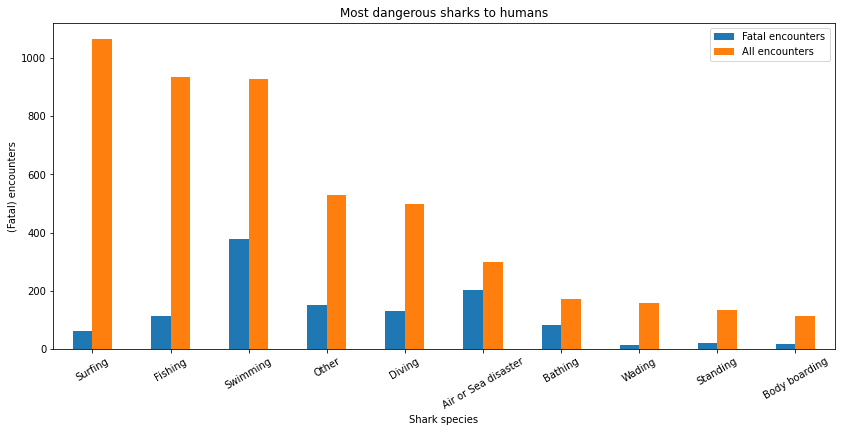

In [ ]:
#Deze vraag ga ik op dezelfde manier als vraag 1 beantwoorden. Waarbij ik d.m.v. herkenningswoorden activiteiten toebedeel. scuba diving, free diving, pearl diving zal allemaal onder diving komen te vallen
#Met minder categoriën is het makkelijker om conclusies te trekken.

df7 = df6
df7["New_activity"] = "Other"
df7['Activity']=df7['Activity'].replace({np.nan : 'Other'})

Unknown = 'involve| or |questionable|thought|possibl|probable|allegedly|None|hoax|believed|Unidentified|\?|Said to be|unlikely'
df7['New_activity'][df7['Activity'].fillna('').str.contains('shark', case = False)] = 'Intervering sharks'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Boat', case = False)] = 'Boating'
df7['New_activity'][df7['Activity'].fillna('').str.contains('fishing', case = False)] = 'Fishing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('surf|surfing', case = False)] = 'Surfing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('swim', case = False)] = 'Swimming'
df7['New_activity'][df7['Activity'].fillna('').str.contains('splash|dang', case = False)] = 'Splashing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('walking', case = False)] = 'Walking'
df7['New_activity'][df7['Activity'].fillna('').str.contains('wading', case = False)   ] = 'Wading'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Kayak|canoe|kakay', case = False)] = 'Kayaking'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Bathing', case = False)] = 'Bathing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Play', case = False)] = 'Playing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Hunt', case = False)] = 'Hunting'
df7['New_activity'][df7['Activity'].fillna('').str.contains('jump', case = False)] = 'Jumping'
df7['New_activity'][df7['Activity'].fillna('').str.contains('stand', case = False)] = 'Standing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Fell|overboard', case = False)] = 'Fell overboard'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Float', case = False)] = 'Floating'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Snork', case = False)] = 'Snorkeling'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Dive|Diving', case = False)] = 'Diving'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Feed', case = False)] = 'Feeding animals'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Padd|SUP', case = False)] = 'Paddling'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Treading', case = False)] = 'Treading water'
df7['New_activity'][df7['Activity'].fillna('').str.contains('ditch|drift|Disaster|capsized|crash|adrift|wreck|accident|aband|swamp|sank|washed|went down|sink|sunk|torp|expl|down|coll|plung|foundered|sub|ground', case = False)] = 'Air or Sea disaster'
df7['New_activity'][df7['Activity'].fillna('').str.contains('washing', case = False)] = 'Washing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Lifesa|rescue', case = False)] = 'During part of a rescue'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Rowing', case = False)] = 'Rowing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Sailing', case = False)] = 'Sailing'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Murder', case = False)] = 'Murder'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Kite', case = False)] = 'Kite boarding'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Collecting', case = False)] = 'Collecting from sea'
df7['New_activity'][df7['Activity'].fillna('').str.contains('Sit', case = False)] = 'Sitting in or near water'
df7['New_activity'][df7['Activity'].fillna('').str.contains('bodyboarding|body-boarding|body boarding|boogie', case = False)] = 'Body boarding'
df7['New_activity'][df7['Activity'].fillna('').str.contains(Unknown, case = False)] = 'Unknown'


#Met pivot table maak ik een draaitabel die direct aangeeft hoeveel totale en (niet)-fatale ongelukken er per type zijn geweest.
df7 = df7[(df7.New_activity != 'Unknown')] 
df7 = df7.pivot_table(columns='Fatal', values = 'Age', index='New_activity',aggfunc='count')
df7['Total'] = df7['N'] + df7['Y']
df7['Fatality'] = round((100*df7['Y']/df7['Total']),2)
df7 = df7.nlargest(10, 'Total')
display(df7)

#Schuine streep duid op twee activiteiten. dit kan een bias worden. 
#Het huidige script zorgt ervoor dat het woord dat het laatste in bovenstaande lijst voorkomt wordt aangemerkt als de activiteit.
#Dit heb ik zo gelaten omdat het maar om een aantal gevallen ging. 
result = df7.drop(columns=['N', 'Fatality'])
axes = result.plot.bar(figsize=(14,6),rot=30)
axes.set_title("Most dangerous sharks to humans")
axes.set_ylabel("(Fatal) encounters")
axes.set_xlabel("Shark species")
plt.xticks(rotation=30, horizontalalignment = 'center')
legend_labels = ["Fatal encounters", "All encounters"]
plt.legend(legend_labels)
